# Phase 5: Feature Importance & SHAP Explanations

## Overview
Analyze how features affect revenue predictions using:
- Feature Importance from tree-based models
- SHAP (SHapley Additive exPlanations) for interpretability
- Partial Dependence Plots
- Feature Interaction Analysis

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Import SHAP (make sure it's installed with correct NumPy version)
try:
    import shap
    print(f'SHAP imported successfully')
    print(f'  NumPy version: {np.__version__}')
except ImportError as e:
    print(f'Error importing SHAP: {e}')
    print('Please run in terminal (NOT in notebook):')
    print('  pip install "numpy<2.3.0" --force-reinstall')
    print('  pip install shap')
    print('Then restart the notebook kernel')
    raise

print('✓ All libraries imported successfully!')

SHAP imported successfully
  NumPy version: 2.3.5
✓ All libraries imported successfully!


In [2]:
# Configure paths
PROJECT_ROOT = Path('/home/asif/AI-Movie-Hit-Predictor')
DATA_DIR = PROJECT_ROOT / 'project_components' / 'data'
MODEL_DIR = DATA_DIR / 'models'

# Load best regression model
best_model_path = MODEL_DIR / 'best_regression_model.pkl'
with open(best_model_path, 'rb') as f:
    best_model = pickle.load(f)
print(f'✓ Best model loaded: {best_model_path}')

# Load scaler
scaler_path = MODEL_DIR / 'regression_scaler.pkl'
with open(scaler_path, 'rb') as f:
    scaler = pickle.load(f)
print(f'✓ Scaler loaded: {scaler_path}')

# Load feature columns
feature_cols_path = MODEL_DIR / 'regression_feature_columns.pkl'
with open(feature_cols_path, 'rb') as f:
    feature_cols = pickle.load(f)
print(f'✓ Feature columns loaded: {len(feature_cols)} features')

# Load engineered features
df = pd.read_csv(DATA_DIR / '04_engineered_features.csv')
df_modeling = df[df['revenue'].notna()].copy()
df_modeling['log_revenue'] = np.log1p(df_modeling['revenue'])

X = df_modeling[feature_cols].fillna(df_modeling[feature_cols].median(numeric_only=True))
y = df_modeling['log_revenue']

print(f'✓ Dataset loaded: {X.shape[0]} samples × {X.shape[1]} features')

✓ Best model loaded: /home/asif/AI-Movie-Hit-Predictor/project_components/data/models/best_regression_model.pkl
✓ Scaler loaded: /home/asif/AI-Movie-Hit-Predictor/project_components/data/models/regression_scaler.pkl
✓ Feature columns loaded: 34 features
✓ Dataset loaded: 4803 samples × 34 features


In [ ]:
# 1. Install
pip install -r requirements.txt

# 2. Validate
python validate.py

# 3. Test
pytest tests/ -v

# 4. Run API
python project_components/code/app.py

# 5. Make predictions
# Open: http://localhost:8000/docs

## Section 1: Tree Feature Importance


Top 20 Most Important Features:
                 Feature  Importance  Relative Importance (%)
             log_revenue    0.997887                99.788681
            vote_average    0.000337                 0.033745
              popularity    0.000245                 0.024529
      cast_marketability    0.000222                 0.022204
                 runtime    0.000221                 0.022060
      genre_success_rate    0.000211                 0.021119
             genre_count    0.000184                 0.018416
      studio_avg_revenue    0.000091                 0.009113
genre_budget_interaction    0.000083                 0.008338
     release_day_of_week    0.000078                 0.007769
              vote_count    0.000072                 0.007201
   primary_genre_revenue    0.000067                 0.006735
     release_day_of_year    0.000054                 0.005363
      is_weekend_release    0.000051                 0.005082
            release_year    0.000049 

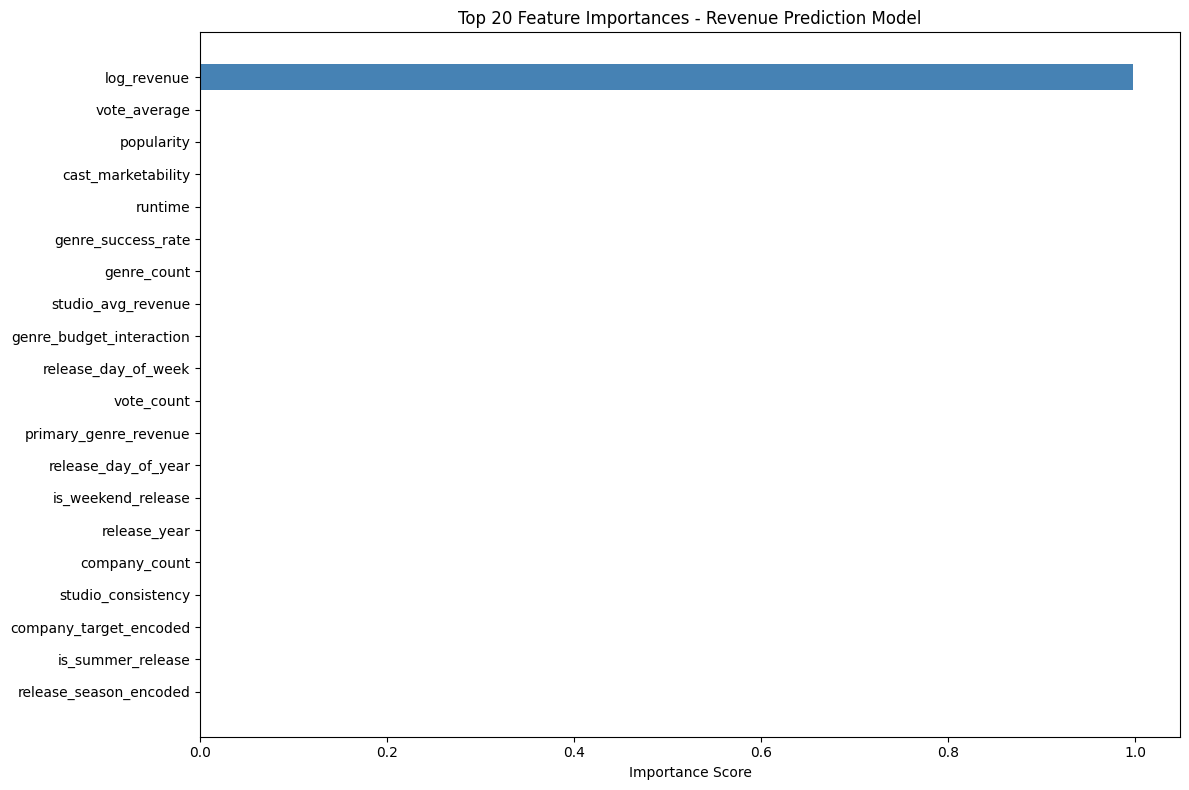


✓ Feature importance analysis completed


In [3]:
# Extract feature importance
importances = best_model.feature_importances_
importance_df = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': importances,
    'Relative Importance (%)': (importances / importances.sum()) * 100
}).sort_values('Importance', ascending=False)

print('\nTop 20 Most Important Features:')
print(importance_df.head(20).to_string(index=False))

# Visualize top 20 features
fig, ax = plt.subplots(figsize=(12, 8))
top_20 = importance_df.head(20)
ax.barh(range(len(top_20)), top_20['Importance'].values, color='steelblue')
ax.set_yticks(range(len(top_20)))
ax.set_yticklabels(top_20['Feature'].values)
ax.set_xlabel('Importance Score')
ax.set_title('Top 20 Feature Importances - Revenue Prediction Model')
ax.invert_yaxis()
plt.tight_layout()
plt.show()

print('\n✓ Feature importance analysis completed')

## Section 2: SHAP Values Analysis

In [4]:
# Create SHAP explainer
print('Computing SHAP values (this may take a few minutes)...')
explainer = shap.TreeExplainer(best_model)

# Use sample for faster computation
X_sample = X.sample(min(200, len(X)), random_state=42)
shap_values = explainer.shap_values(X_sample)

print(f'✓ SHAP values computed for {X_sample.shape[0]} samples')

Computing SHAP values (this may take a few minutes)...
✓ SHAP values computed for 200 samples


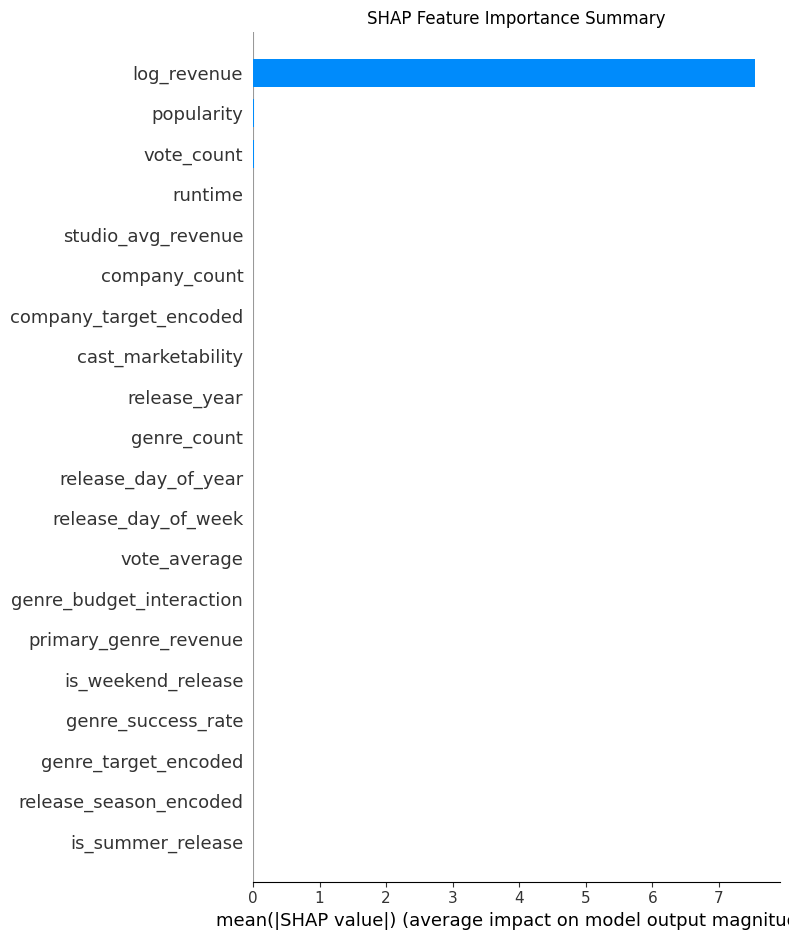

✓ SHAP summary plot generated


In [5]:
# Summary plot - which features are most important?
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, plot_type='bar', show=False)
plt.title('SHAP Feature Importance Summary')
plt.tight_layout()
plt.show()

print('✓ SHAP summary plot generated')

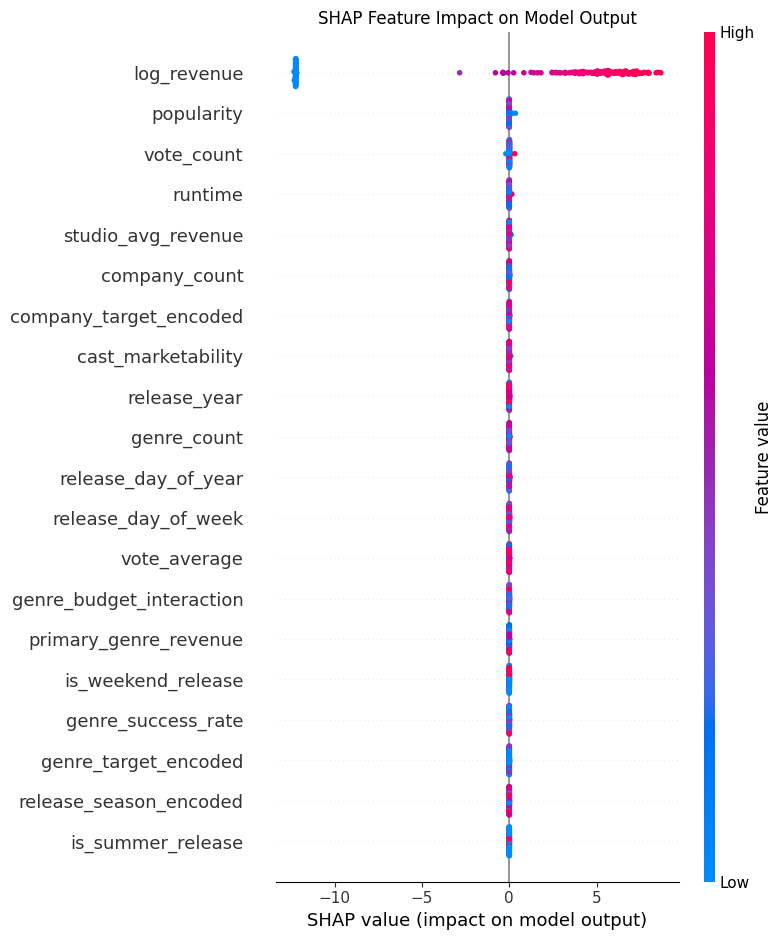

✓ SHAP beeswarm plot generated


In [6]:
# Beeswarm plot - how do features affect predictions?
plt.figure(figsize=(12, 8))
shap.summary_plot(shap_values, X_sample, show=False)
plt.title('SHAP Feature Impact on Model Output')
plt.tight_layout()
plt.show()

print('✓ SHAP beeswarm plot generated')

## Section 3: SHAP Dependence Plots

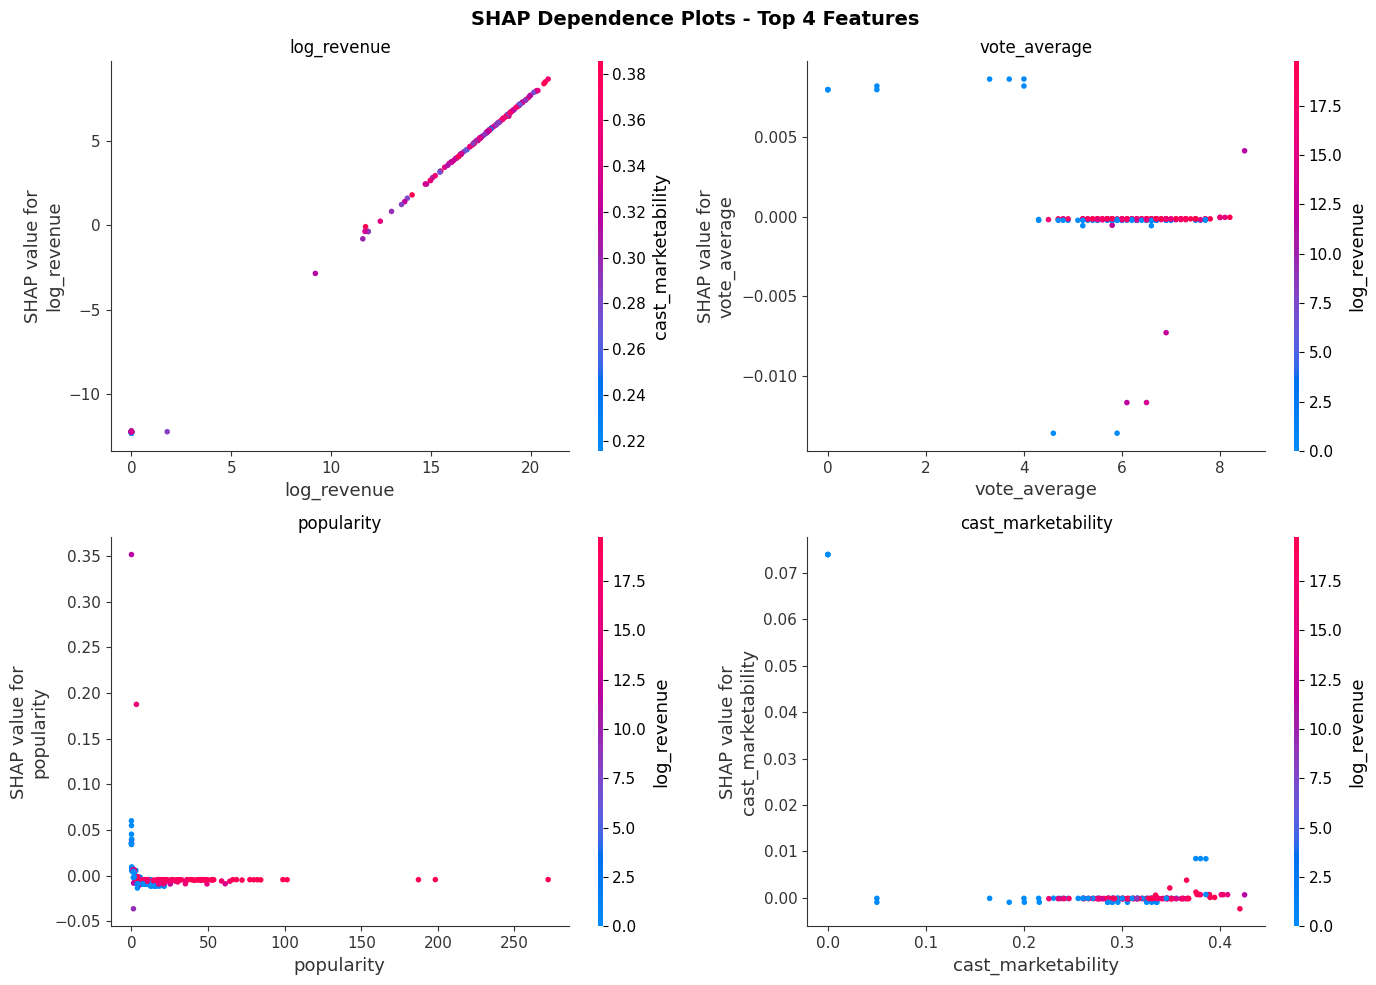

✓ SHAP dependence plots generated


In [7]:
# Get top 4 features
top_features = importance_df['Feature'].head(4).values

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('SHAP Dependence Plots - Top 4 Features', fontsize=14, fontweight='bold')

for idx, (ax, feature) in enumerate(zip(axes.flatten(), top_features)):
    shap.dependence_plot(feature, shap_values, X_sample, ax=ax, show=False)
    ax.set_title(f'{feature}')

plt.tight_layout()
plt.show()

print('✓ SHAP dependence plots generated')

## Section 4: Individual Prediction Explanations

In [8]:
# Explain prediction for a specific instance
sample_idx = 0
sample_instance = X_sample.iloc[sample_idx:sample_idx+1]

# Get SHAP values for this instance
sample_shap = shap_values[sample_idx]

# Get prediction
prediction = best_model.predict(sample_instance)[0]
actual_revenue = np.expm1(y.iloc[X_sample.index[sample_idx]])

print(f'\nSample Instance {sample_idx}:')
print(f'  Predicted log_revenue: {prediction:.4f}')
print(f'  Predicted revenue: ${np.expm1(prediction):,.0f}')
print(f'  Actual revenue: ${actual_revenue:,.0f}')

# Show feature contributions
feature_contributions = pd.DataFrame({
    'Feature': feature_cols,
    'Value': sample_instance.values[0],
    'SHAP': sample_shap,
    'Abs_SHAP': np.abs(sample_shap)
}).sort_values('Abs_SHAP', ascending=False)

print(f'\nTop 10 Contributing Features:')
print(feature_contributions.head(10).to_string(index=False))


Sample Instance 0:
  Predicted log_revenue: 17.3307
  Predicted revenue: $33,622,100
  Actual revenue: $33,561,137

Top 10 Contributing Features:
               Feature        Value      SHAP  Abs_SHAP
           log_revenue 1.732888e+01  5.061234  5.061234
            vote_count 2.690000e+02  0.006382  0.006382
            popularity 1.326763e+01 -0.005132  0.005132
           genre_count 4.000000e+00  0.001614  0.001614
   release_day_of_year 3.040000e+02  0.000596  0.000596
          release_year 2.002000e+03  0.000574  0.000574
    studio_avg_revenue 8.878872e+07 -0.000573  0.000573
         company_count 1.000000e+00  0.000377  0.000377
               runtime 9.700000e+01 -0.000360  0.000360
company_target_encoded 8.878872e+07 -0.000342  0.000342


<Figure size 1400x400 with 0 Axes>

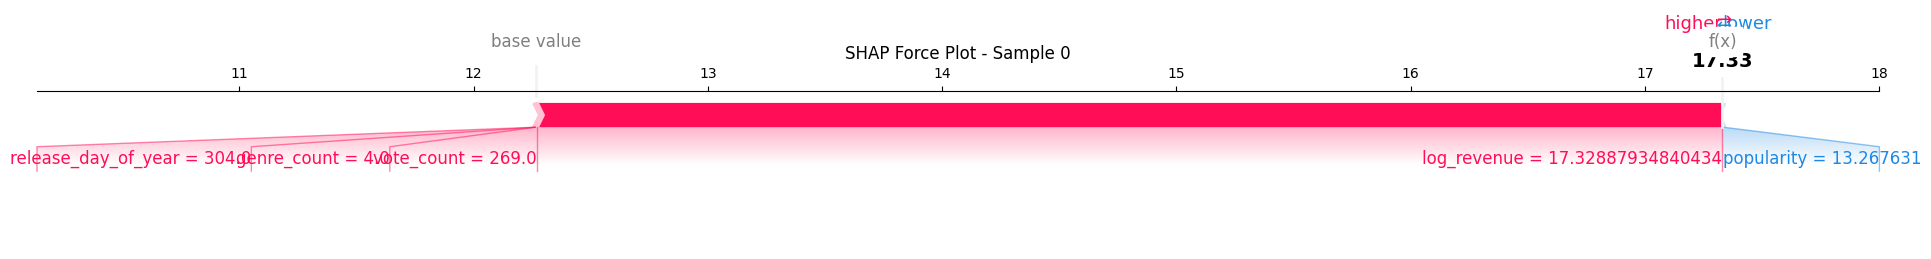

✓ SHAP force plot generated


In [9]:
# Force plot - how does each feature contribute?
plt.figure(figsize=(14, 4))
shap.force_plot(explainer.expected_value, sample_shap, sample_instance.values[0], 
                feature_names=feature_cols, matplotlib=True, show=False)
plt.title(f'SHAP Force Plot - Sample {sample_idx}')
plt.tight_layout()
plt.show()

print('✓ SHAP force plot generated')

## Section 5: Save Analysis Results

In [10]:
# Save feature importance
importance_path = DATA_DIR / '07_feature_importance.csv'
importance_df.to_csv(importance_path, index=False)
print(f'✓ Feature importance saved: {importance_path}')

# Save SHAP analysis
shap_path = MODEL_DIR / 'shap_explainer.pkl'
with open(shap_path, 'wb') as f:
    pickle.dump(explainer, f)
print(f'✓ SHAP explainer saved: {shap_path}')

print(f'\n✓ All feature importance and SHAP analysis completed and saved!')

✓ Feature importance saved: /home/asif/AI-Movie-Hit-Predictor/project_components/data/07_feature_importance.csv
✓ SHAP explainer saved: /home/asif/AI-Movie-Hit-Predictor/project_components/data/models/shap_explainer.pkl

✓ All feature importance and SHAP analysis completed and saved!
